In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Image_Augmentation.py
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (14).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (9).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (66).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (29).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (46).jpg
/kaggle/input/mamography

In [3]:
!pip install -q grad-cam

In [4]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import kornia.augmentation as K
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import random
import warnings
import os

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [5]:
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Dataset

In [8]:
cancer_path = '/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/'
non_cancer_path = '/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Non-Cancer/'

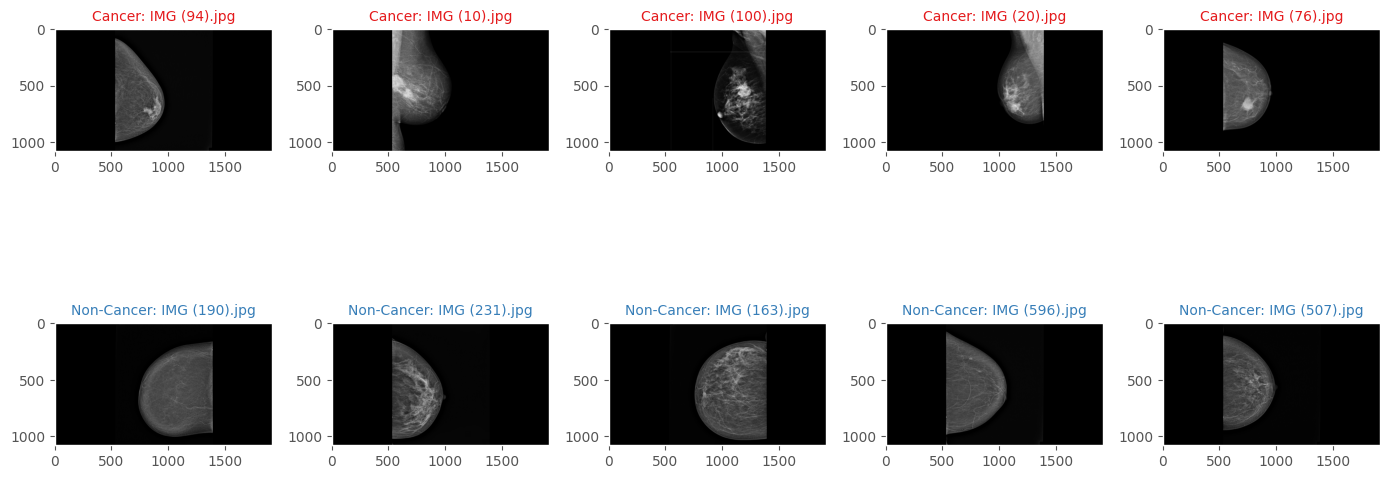

In [11]:
plt.rcParams['axes.grid'] = False
colors = sns.color_palette('Set1', 2)
fig, ax = plt.subplots(2, 5, figsize=(14, 7))
ax = ax.flatten()

for i in range(5):
    image_file = random.choice(os.listdir(cancer_path))
    image = Image.open(cancer_path + image_file)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f'Cancer: {image_file}', color=colors[0], fontsize=10)

for i in range(5, 10):
    image_file = random.choice(os.listdir(non_cancer_path))
    image = Image.open(non_cancer_path + image_file)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f'Non-Cancer: {image_file}', color=colors[1], fontsize=10)

plt.tight_layout()
plt.show()

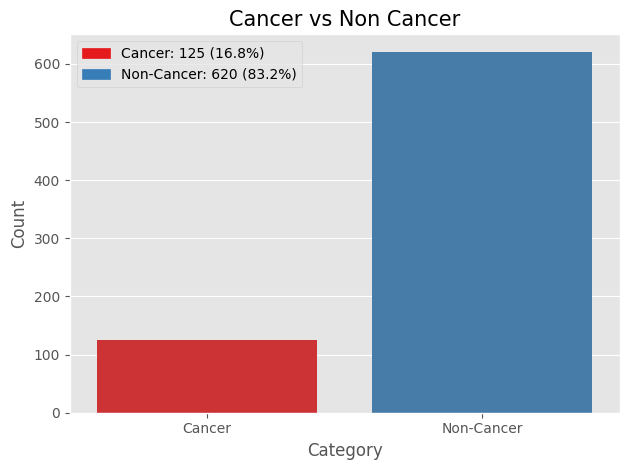

In [13]:
plt.rcParams['axes.grid'] = True

df = pd.DataFrame({
    'Category': ['Cancer', 'Non-Cancer'],
    'Count': [len(os.listdir(cancer_path)), len(os.listdir(non_cancer_path))]
})
total = df['Count'].sum()
df['Percentage'] = df['Count'] / total * 100

ax = sns.barplot(x='Category', y='Count', data=df, palette=colors)
legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=patches, title_fontsize='13', loc='best')
plt.title('Cancer vs Non Cancer', fontsize=15)
plt.tight_layout()
plt.show()

# Augmenting the Images with Kornia

In [14]:
augmented_cancer_path = '/kaggle/working/augmented_dataset/cancer/'
augmented_non_cancer_path = '/kaggle/working/augmented_dataset/non-cancer/'

try:
    os.mkdir('/kaggle/working/augmented_dataset')
    os.mkdir('/kaggle/working/augmented_dataset/cancer')
    os.mkdir('/kaggle/working/augmented_dataset/non-cancer')
except:
    pass

In [17]:
print('Original dataset size: ', len(os.listdir(cancer_path)) + len(os.listdir(non_cancer_path)))
print('Augmented dataset size: ', len(os.listdir(augmented_cancer_path)) + len(os.listdir(augmented_non_cancer_path)))

Original dataset size:  745
Augmented dataset size:  5960


**7 augmentations to each image,also the original image.**

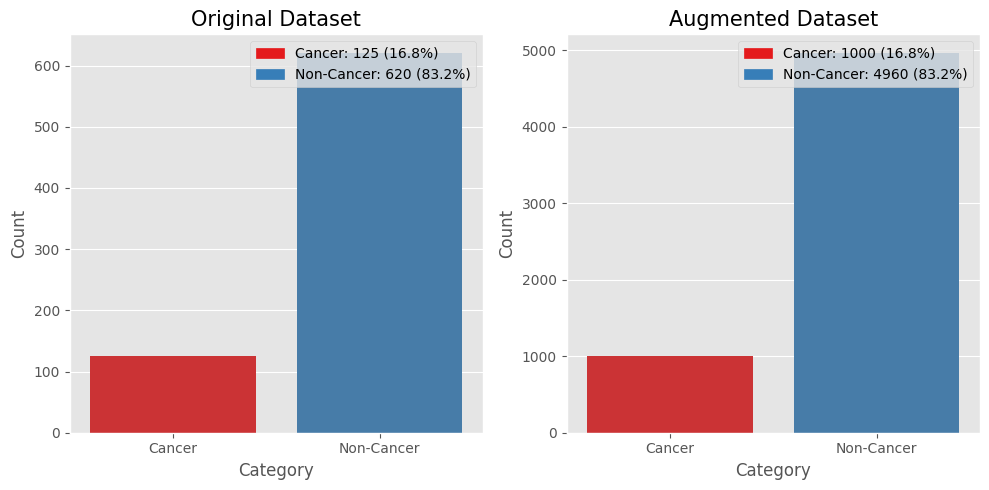

In [22]:
df = pd.DataFrame({
    'Category': ['Cancer', 'Non-Cancer'],
    'Count': [len(os.listdir(cancer_path)), len(os.listdir(non_cancer_path))]
})
total = df['Count'].sum()
df['Percentage'] = df['Count'] / total * 100

df_augmented = pd.DataFrame({
    'Category': ['Cancer', 'Non-Cancer'],
    'Count': [len(os.listdir(augmented_cancer_path)), len(os.listdir(augmented_non_cancer_path))]
})
total_augmented = df_augmented['Count'].sum()
df_augmented['Percentage'] = df_augmented['Count'] / total_augmented * 100

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x='Category', y='Count', data=df, palette=colors, ax=ax[0])
sns.barplot(x='Category', y='Count', data=df_augmented, palette=colors, ax=ax[1])

legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax[0].legend(handles=patches, title_fontsize='13', loc='best')
ax[0].set_title('Original Dataset', fontsize=15)

legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df_augmented.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax[1].legend(handles=patches, title_fontsize='13', loc='best')
ax[1].set_title('Augmented Dataset', fontsize=15)

plt.tight_layout()
plt.show()

# Splitting the Augmented Dataset into Train, Validation, and Test Sets

In [23]:
def create_directory(path: str) -> None:
    try:
        os.makedirs(path)
    except FileExistsError:
        pass


def split_data(data: list, train_ratio: float = 0.8, val_ratio: float = 0.1) -> Tuple[list, list, list]:
    np.random.shuffle(data)
    train_end = int(len(data) * train_ratio)
    val_end = int(len(data) * (train_ratio + val_ratio))
    return data[:train_end], data[train_end:val_end], data[val_end:]


def save_images(data: list, source_dir: str, target_dir: str) -> None:
    for filename in data:
        img = Image.open(os.path.join(source_dir, filename))
        img.save(os.path.join(target_dir, filename))


dataset_dirs = [
    '/kaggle/working/dataset/train/cancer',
    '/kaggle/working/dataset/train/non-cancer',
    '/kaggle/working/dataset/val/cancer',
    '/kaggle/working/dataset/val/non-cancer',
    '/kaggle/working/dataset/test/cancer',
    '/kaggle/working/dataset/test/non-cancer'
]

for dir_path in dataset_dirs:
    create_directory(dir_path)

cancer = os.listdir(augmented_cancer_path)
non_cancer = os.listdir(augmented_non_cancer_path)

cancer_train, cancer_val, cancer_test = split_data(cancer)
non_cancer_train, non_cancer_val, non_cancer_test = split_data(non_cancer)

save_images(cancer_train, augmented_cancer_path, '/kaggle/working/dataset/train/cancer')
save_images(cancer_val, augmented_cancer_path, '/kaggle/working/dataset/val/cancer')
save_images(cancer_test, augmented_cancer_path, '/kaggle/working/dataset/test/cancer')

save_images(non_cancer_train, augmented_non_cancer_path, '/kaggle/working/dataset/train/non-cancer')
save_images(non_cancer_val, augmented_non_cancer_path, '/kaggle/working/dataset/val/non-cancer')
save_images(non_cancer_test, augmented_non_cancer_path, '/kaggle/working/dataset/test/non-cancer')

In [ ]:
Creating Datasets and Dataloaders for Training

In [24]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_dir = 'dataset'

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.2470, 0.2470, 0.2470], [0.2364, 0.2364, 0.2364])
])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
def find_mean_std(loader: DataLoader) -> Tuple[torch.Tensor, torch.Tensor]:
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

mean, std = find_mean_std(dataloaders['train'])
print('Mean: ', mean)
print('Std: ', std)

Mean:  tensor([-0.8612, -0.8612, -0.8612])
Std:  tensor([0.4434, 0.4434, 0.4434])


In [27]:
class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None
        
    def save_cam_samples(self, model: models.resnet.ResNet, epoch_nr: int) -> None:
        samples = [
            'samples/IMG (1).jpg',
            'samples/IMG (10).jpg',
            'samples/IMG (103).jpg',
            'samples/IMG (107).jpg',
            'samples/IMG (112).jpg'
        ]

        targets = [1, 1, 1, 1, 1]
        
        target_layer = [model.layer4[-1]]
        cam = GradCAM(model=model, target_layers=target_layer)

        plt.rcParams['axes.grid'] = False

        for i, (image_path, target) in enumerate(zip(samples, targets)):
            image = Image.open(image_path).convert('RGB')
            image_tensor = transforms.ToTensor()(image).unsqueeze(0)
            
            image = transforms.ToTensor()(image)
            image = image.numpy().transpose((1, 2, 0))
            image = np.clip(image, 0, 1)
            
            targets = [ClassifierOutputTarget(target)]
            grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

            filename = image_path.split('/')[-1].split('.')[0]
            filetype = image_path.split('/')[-1].split('.')[1]
            plt.imshow(visualization)
            plt.axis('off') 
            plt.savefig(f'samples/{filename}-cam-epoch-{epoch_nr}.{filetype}', bbox_inches='tight', pad_inches=0)
            plt.close()

    def train(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        if current_epoch_nr == 1:
            self.save_cam_samples(self.model, 0)

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            _, preds = torch.max(y_hat, 1)
            loss = self.criterion(y_hat, y)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).data.item()
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_acc=round(n_corrects / total, 5),
                             train_loss=round(running_loss / total, 5))
            
        self.scheduler.step()

        train_accuracy = n_corrects / total
        train_loss = running_loss / num_batches

        return train_accuracy, train_loss

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_acc=round(n_corrects / total, 5),
                                 val_loss=round(running_loss / total, 5))

        val_accuracy = n_corrects / total
        val_loss = running_loss / num_batches

        self.save_cam_samples(self.model, current_epoch_nr)
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f'epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth'
            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(self.checkpoint_path, checkpoint_name)

        return val_accuracy, val_loss

    def test(self) -> Tuple[float, float, list, list, models.resnet.ResNet]:
        self.model.eval()

        num_batches = len(self.test_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        targets = []
        predictions = []

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                
                targets.extend(y.cpu().numpy())
                predictions.extend(preds.cpu().numpy())

                loop.set_description('Testing')
                loop.set_postfix(test_acc=round(n_corrects / total, 5),
                                 test_loss=round(running_loss / total, 5))

        test_accuracy = n_corrects / total
        test_loss = running_loss / num_batches
        
        print('\nTest Accuracy: ', test_accuracy)
        print('Test Loss: ', test_loss)

        self.model.load_state_dict(torch.load(self.best_model_path))
        
        return test_accuracy, test_loss, targets, predictions, self.model
    
# I will use these samples to visualize CAM results
samples = [
    cancer_path + 'IMG (1).jpg',
    cancer_path + 'IMG (10).jpg',
    cancer_path + 'IMG (103).jpg',
    cancer_path + 'IMG (107).jpg',
    cancer_path + 'IMG (112).jpg',
]
os.makedirs('samples', exist_ok=True)
for sample in samples:
    img = Image.open(sample)
    img.save('samples/' + sample.split('/')[-1])

In [28]:
model = models.resnet50(weights='IMAGENET1K_V2')
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


In [29]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = '/kaggle/working/checkpoints'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path
)

histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()

Testing: 100%|██████████| 38/38 [00:04<00:00,  7.81it/s, test_acc=0.993, test_loss=0.01]   


Test Accuracy:  0.9932885906040269
Test Loss:  0.15721047113765962


# Analyzing the Results

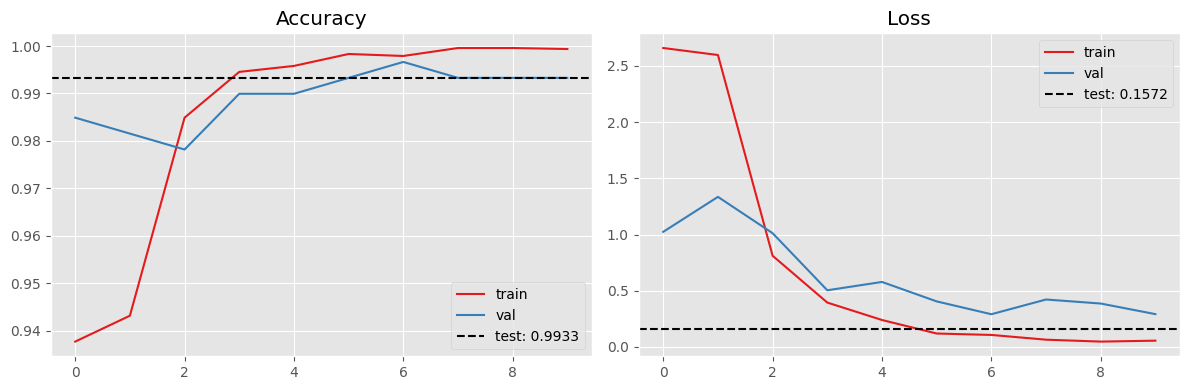

In [30]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

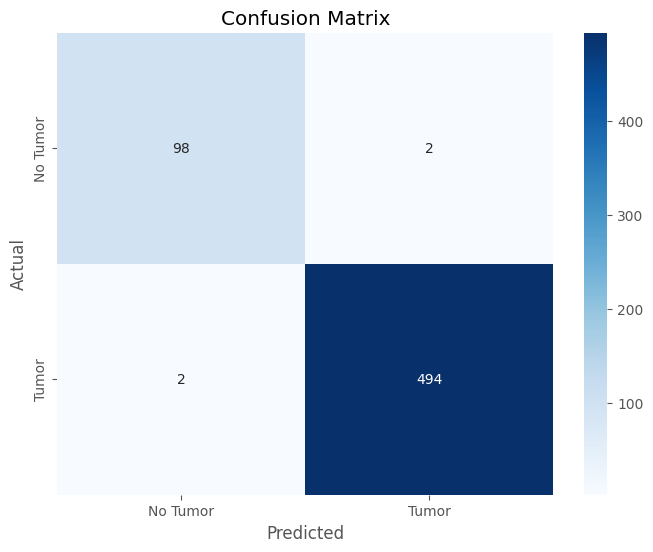

In [31]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
print(classification_report(targets, predictions, target_names=['Non-Cancer', 'Cancer']))

              precision    recall  f1-score   support

  Non-Cancer       0.98      0.98      0.98       100
      Cancer       1.00      1.00      1.00       496

    accuracy                           0.99       596
   macro avg       0.99      0.99      0.99       596
weighted avg       0.99      0.99      0.99       596



# Model Explanation with GradCAM

In [33]:
def plot_cam(model: models.resnet.ResNet, image_paths: list, targets: list) -> None:
    model = model.eval()
    
    target_layer = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layer)

    plt.rcParams['axes.grid'] = False
    fig, axs = plt.subplots(2, 4, figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')
        image = transforms.ToTensor()(image)
        
        image_tensor = image.unsqueeze(0)
        
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        
        targets = [ClassifierOutputTarget(target)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

        axs[1, i].imshow(image)
        axs[1, i].set_title('Original')

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('Grad-CAM')

    plt.tight_layout()
    plt.show()

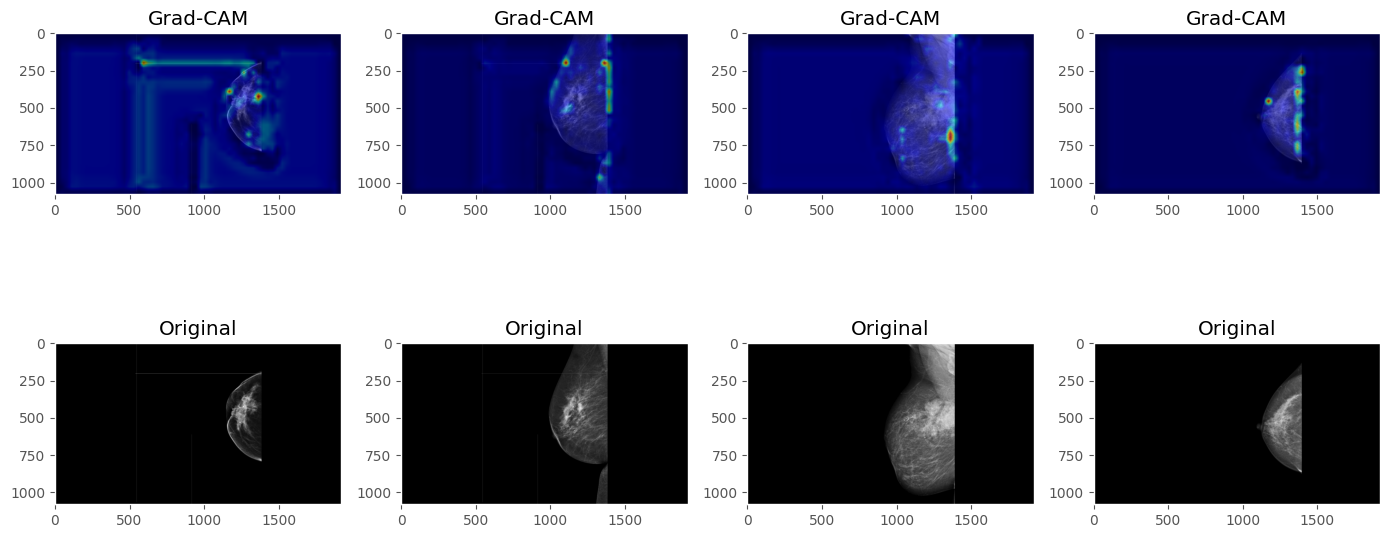

In [34]:
image_paths = [os.path.join(cancer_path, filename) for filename in os.listdir(cancer_path)][24:28]
plot_cam(best_model, image_paths, [1] * 4)

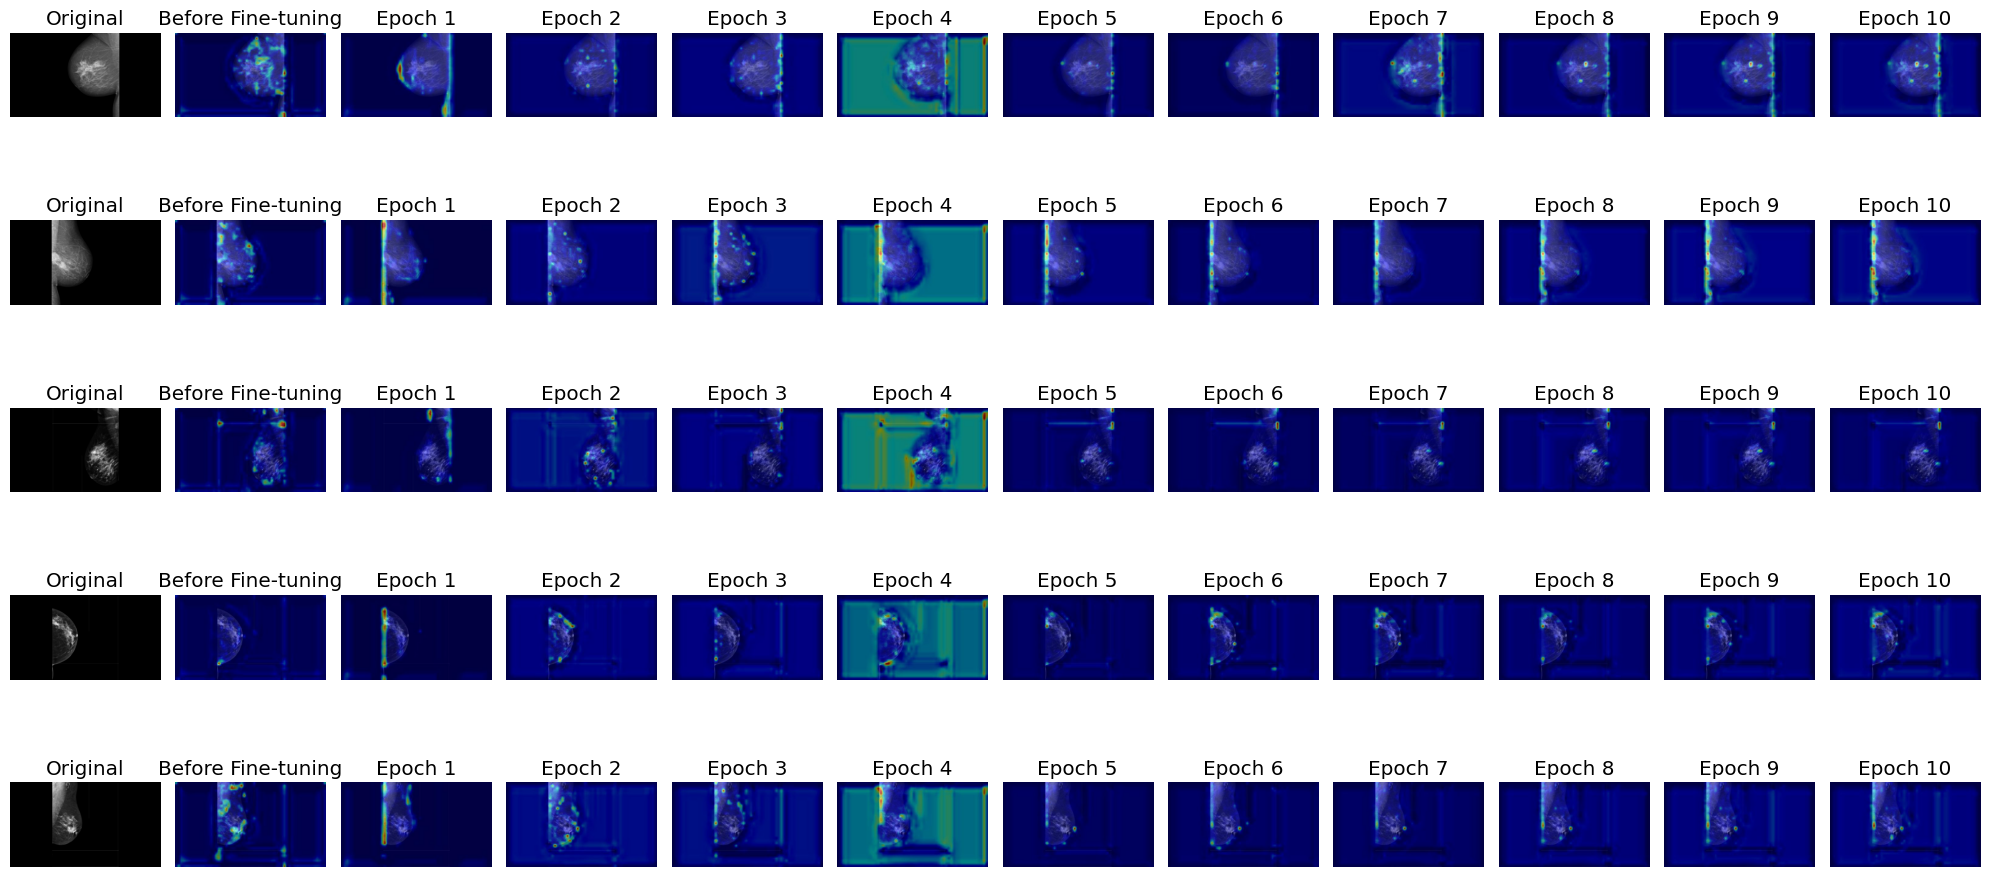

In [35]:
samples = [
    '/kaggle/working/samples/IMG (1).jpg',
    '/kaggle/working/samples/IMG (10).jpg',
    '/kaggle/working/samples/IMG (103).jpg',
    '/kaggle/working/samples/IMG (107).jpg',
    '/kaggle/working/samples/IMG (112).jpg'
]

fig, axs = plt.subplots(len(samples), max_epochs + 2, figsize=(20, 10))
start_index = 0
for row in range(len(samples)):
    filename = Image.open(samples[start_index])
    axs[row, 0].imshow(filename, cmap='gray')
    axs[row, 0].set_title('Original')
    axs[row, 0].axis('off')
    start_index += 1

    original_filename = filename.filename.split("/")[-1].split(".")[0]

    for col in range(1, max_epochs + 2):
        filename = Image.open(f'samples/{original_filename}-cam-epoch-{col-1}.jpg')
        axs[row, col].imshow(filename, cmap='gray')
        if col == 0:
            title = "Original"
        if col == 1:
            title = "Before Fine-tuning"
        if col > 1:
            title = f'Epoch {col - 1}'
        axs[row, col].set_title(title)
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
https://github.com/jacobgil/pytorch-grad-cam
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
https://arxiv.org/abs/1610.02391
https://arxiv.org/abs/1512.03385
    